# Evolutionary Deep Learning

## Load Dataset

In [134]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

iris = datasets.load_iris()
X = iris.data
y = iris.target

df = pd.DataFrame(X, columns=iris.feature_names)
df["class"] = y

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## Create Model

### Binarize Outputs

In [136]:
X_scaled = StandardScaler().fit_transform(X)
y_binarized = LabelBinarizer().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binarized, test_size=0.2, random_state=0)

X_train[:3], y_train[:3]

(array([[ 0.67450115,  0.09821729,  0.99010798,  0.79067065],
        [-0.53717756, -0.13197948,  0.42173371,  0.3957741 ],
        [-0.7795133 ,  1.01900435, -1.2833891 , -1.3154443 ]]),
 array([[0, 0, 1],
        [0, 1, 0],
        [1, 0, 0]]))

In [203]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(layers):
    model = Sequential()
    for i, nodes in enumerate(layers):
        if i == 0:
            model.add(Dense(nodes, input_dim=X_train.shape[1], activation="relu"))
        else:
            model.add(Dense(nodes, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation="softmax")) 
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

In [255]:
test_model = create_model([5, 5, 5])
test_model.summary()
history = test_model.fit(X_train, y_train, epochs=50, validation_data=[X_test, y_test], verbose=0)

Model: "sequential_885"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3510 (Dense)          (None, 5)                 25        
                                                                 
 dense_3511 (Dense)          (None, 5)                 30        
                                                                 
 dense_3512 (Dense)          (None, 5)                 30        
                                                                 
 dropout_856 (Dropout)       (None, 5)                 0         
                                                                 
 dense_3513 (Dense)          (None, 3)                 18        
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


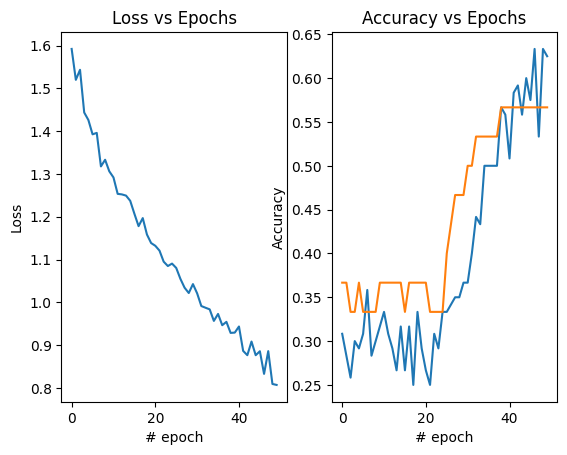

In [256]:
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history["loss"])
plt.xlabel("# epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])

plt.xlabel("# epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")

plt.show()

# Evolutionary Algorithm

In [257]:
import random
from deap import base, creator, tools, algorithms

def eval_model(individual):
    layers = [int(x) for x in individual]

    test_model = create_model(layers)
    history = test_model.fit(X_train, y_train, epochs=50, validation_data=[X_test, y_test], verbose=0)
    
    return history.history["val_accuracy"][-1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 5, 200)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", eval_model)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=5, up=200, indpb=0.3)
toolbox.register("select", tools.selTournament, tournsize=3)

## Run the EA

In [258]:
from tqdm import tqdm

population = toolbox.population(n=20)

NGEN = 10
for gen in tqdm(range(NGEN), desc="Iterating"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.5)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = [fit]
    population = toolbox.select(offspring, k=len(population))

top5 = tools.selBest(population, k=5)

Iterating: 100%|██████████████████████████████████████████████████████████████████| 10/10 [02:19<00:00, 13.94s/it]


In [259]:
fits = toolbox.map(toolbox.evaluate, top5)
for fit, ind in zip(fits, top5):
    print(ind, "-->", fit)

[57, 146, 170] --> 1.0
[95, 38, 82] --> 1.0
[189, 38, 117] --> 1.0
[57, 146, 170] --> 1.0
[48, 70, 38] --> 1.0


In [260]:
tuned_model = create_model([189, 38, 117])
tuned_model.summary()
history = tuned_model.fit(X_train, y_train, epochs=50, validation_data=[X_test, y_test], verbose=0)

Model: "sequential_1091"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4334 (Dense)          (None, 189)               945       
                                                                 
 dense_4335 (Dense)          (None, 38)                7220      
                                                                 
 dense_4336 (Dense)          (None, 117)               4563      
                                                                 
 dropout_1062 (Dropout)      (None, 117)               0         
                                                                 
 dense_4337 (Dense)          (None, 3)                 354       
                                                                 
Total params: 13,082
Trainable params: 13,082
Non-trainable params: 0
_________________________________________________________________


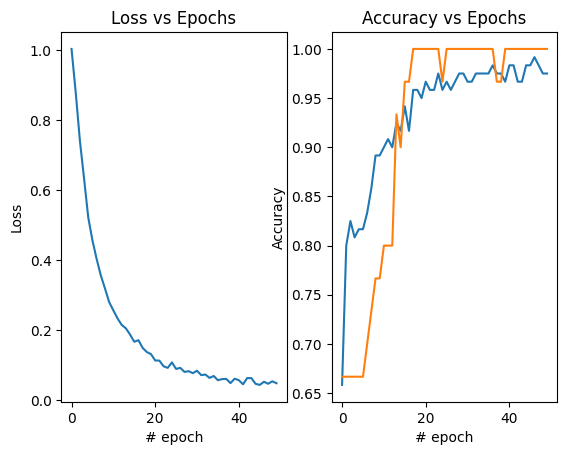

In [261]:
plt.subplot(1, 2, 1)
plt.plot(history.epoch, history.history["loss"])
plt.xlabel("# epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.epoch, history.history["accuracy"])
plt.plot(history.epoch, history.history["val_accuracy"])

plt.xlabel("# epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")

plt.show()